In [1]:
import inox
import inox.nn as nn
import jax
import jax.numpy as jnp
import optax

from functools import partial
from inox.random import PRNG
from jax import Array
from typing import *

from priors.nn import *
from priors.score import *
from priors.plots import corner

## Data

In [2]:
rng = PRNG(0)
n = 8192

domain = -3.0 * jnp.ones(10), 3.0 * jnp.ones(10)

def generate(n: int) -> Array:
    return jnp.sort(rng.normal((n, 10)), axis=-1)

def linear(A: Array, x: Array):
    return jnp.einsum('...ij,...j->...i', A, x)

x = generate(n)
A = rng.normal((n, 3, 10)) / 10 ** 0.5
y = linear(A, x) + 1e-2 * rng.normal((n, 3))

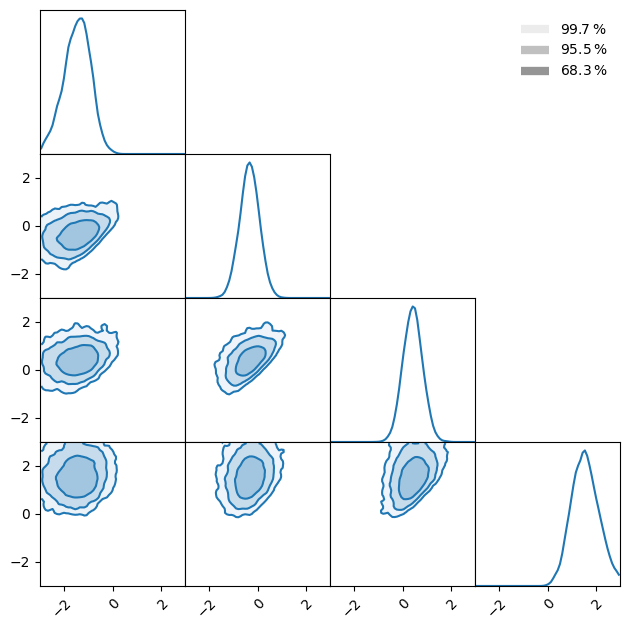

In [3]:
fig = corner(x[..., ::3], domain=domain, smooth=1)

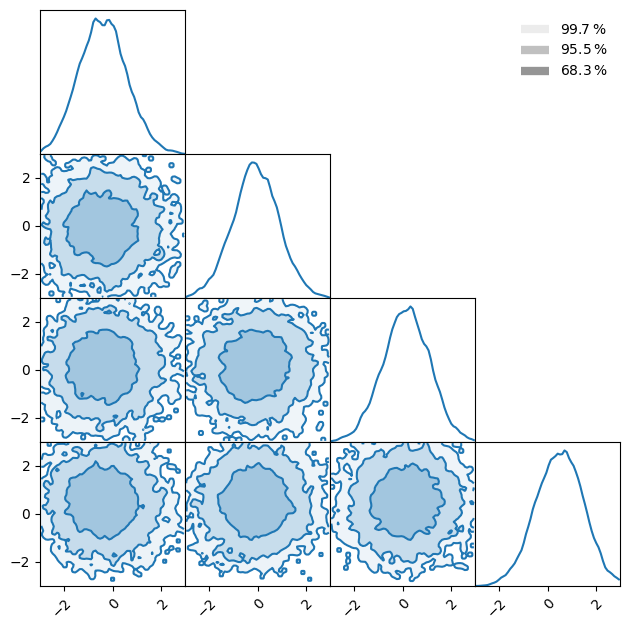

In [4]:
def sample(model, A, y, key):
    sde = ReverseSDE(
        PosteriorScoreModel(
            model=model,
            y=y,
            A=lambda x: linear(A, x),
            noise=1e-2,
            gamma=1.0,
        )
    )

    return sde(shape=(n, 10), steps=64, corrections=1, key=key)

x_bis = sample(StandardScoreModel(), A, y, key=rng.split())
fig = corner(x_bis[..., ::3], domain=domain, smooth=1)

## Training

In [5]:
class TimeMLP(nn.Module):
    def __init__(self, features: int, embedding: int = 64, key: Array = None, **kwargs):
        self.mlp = MLP(features + embedding, features, **kwargs, key=key)

    @staticmethod
    @partial(jnp.vectorize, signature='(m),(n)->(p)')
    def cat(x: Array, y: Array) -> Array:
        return jnp.concatenate((x, y))

    @inox.jit
    def __call__(self, x: Array, t: Array) -> Array:
        return self.mlp(self.cat(x, t))

In [6]:
def train(x, A, y, key):
    rng = PRNG(key)

    with set_rng(rng):
        model = ScoreModel(TimeMLP(features=10, embedding=16, hidden_features=[256, 256], normalize=True), embedding=16)
        static, params, others = model.partition(nn.Parameter)

    scheduler = optax.linear_schedule(init_value=1e-3, end_value=1e-5, transition_steps=8192)
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def sgd_step(params, others, opt_state, rng, x, A):
        def ell(params):
            model = static(params, others)

            z = rng.normal(x.shape)
            t = rng.uniform(x.shape[:-1])

            return model.loss(x, z, t, lambda x: linear(A, x))

        loss, grads = jax.value_and_grad(ell)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return loss, params, opt_state, rng

    for step in range(8192):
        i = rng.randint(shape=(256,), minval=0, maxval=len(y))

        loss, params, opt_state, rng = sgd_step(params, others, opt_state, rng, x[i], A[i])

        if step % 1024 == 0:
            print(f'({step})', float(loss))

    return static(params, others)

(0) 1.3790936470031738
(1024) 0.4256872534751892
(2048) 0.39506039023399353
(3072) 0.47951310873031616
(4096) 0.3681304454803467
(5120) 0.4077022969722748
(6144) 0.43922051787376404
(7168) 0.38840168714523315


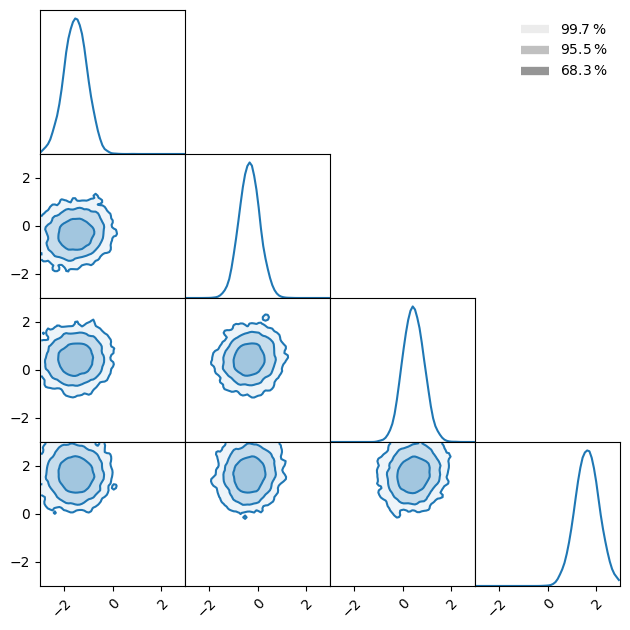

In [7]:
model = train(x_bis, A, y, key=rng.split())
x_bis = sample(model, A, y, key=rng.split())
fig = corner(x_bis[..., ::3], domain=domain, smooth=1)

(0) 1.8076658248901367
(1024) 0.4593676030635834
(2048) 0.43636876344680786
(3072) 0.49838656187057495
(4096) 0.5170974731445312
(5120) 0.44875550270080566
(6144) 0.3355438709259033
(7168) 0.4238644540309906


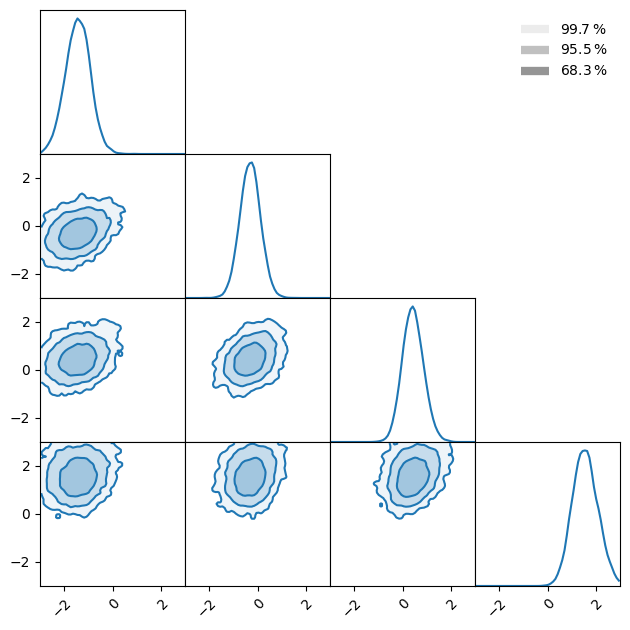

In [8]:
model = train(x_bis, A, y, key=rng.split())
x_bis = sample(model, A, y, key=rng.split())
fig = corner(x_bis[..., ::3], domain=domain, smooth=1)

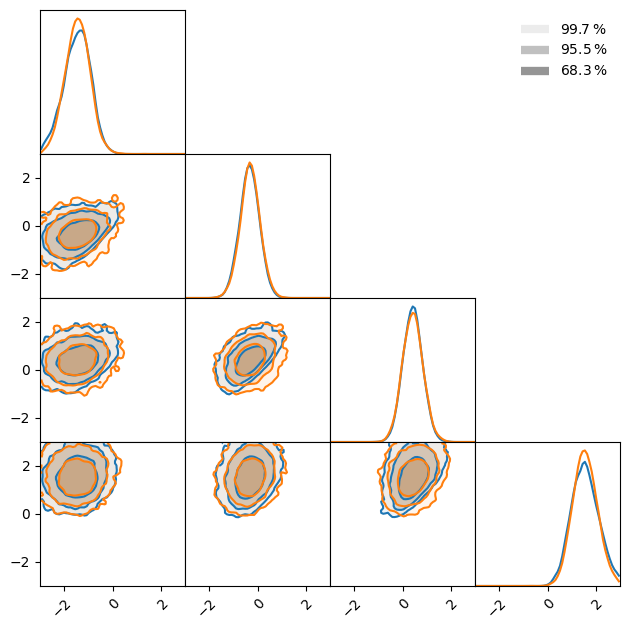

In [9]:
sde = ReverseSDE(model)

x_ter = sde(shape=(n, 10), steps=64, key=rng.split())

fig = corner(x[..., ::3], domain=domain, smooth=1)
fig = corner(x_ter[..., ::3], domain=domain, smooth=1, figure=fig)